In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import networkx as nx
from collections import defaultdict
import statsmodels.api as sm

In [252]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2022` >=500000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
    'Jor',
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))
df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country'].isin(possible_iso))]

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'country'}, inplace=True)
data['country']=data['country'].apply(lambda x: x.lower())
data=data.groupby(by=['incomelevel', 'country','region']).agg({'gdp_per_capita':'mean', 'population':'mean', 'padded_population_of_researchers':'mean'}).reset_index()


df['discipline']=df['subjarea'].apply(find_cat)
df[df['discipline'].isna()].reset_index(drop=True, inplace=True)
df=df.groupby(['Mention_country','Aff_country', 'year'])['count'].sum().reset_index().rename(columns={'count':'weight', 'Mention_country':'dst','Aff_country':'src'})


df['income_src']=df['src'].map(data.set_index('country')['incomelevel'])
df['income_dst']=df['dst'].map(data.set_index('country')['incomelevel'])
df['region_src']=df['src'].map(data.set_index('country')['region'])
df['region_dst']=df['dst'].map(data.set_index('country')['region'])


df=df[df['income_src']!='INX']
df=df[df['income_dst']!='INX']



In [140]:
def find_cat(subject):  
    social_sciences=['PSYC', 'SOCI', 'DECI', 'ARTS', 'ECON', 'BUSI']
    health_sciences=['MEDI', 'NURS', 'DENT', 'HEAL', 'VETE']
    physical_sciences=['CHEM', 'EART', 'ENER', 'CENG',  'ENVI','MATE', 'ENGI', 'MATH', 'PHYS','COMP']
    life_sciences=['PHAR', 'NEUR', 'AGRI', 'IMMU', 'BIOC']
    if subject in social_sciences:
        return 'Social sciences'
    elif  subject in health_sciences:
        return 'Health sciences'
    elif subject in physical_sciences:
        return 'Physical sciences'
    elif subject in life_sciences:
        return 'Life sciences'
    else:
        return None

In [244]:
# Create pivot table
pivot = df.pivot_table(
    index='region_src',
    columns='region_dst',
    values='weight',
    aggfunc='sum'
).fillna(0)




# Copy matrix and set diagonal to NaN (ignore self-study)
pivot_nodiag = pivot.copy()
np.fill_diagonal(pivot_nodiag.values, np.nan)

# Compute mean attention sent (outgoing) and received (incoming)
outgoing = pivot_nodiag.sum(axis=1, skipna=True)  # who studies others
incoming = pivot_nodiag.sum(axis=0, skipna=True)  # who is studied by others

# Combine into one dataframe
asymmetry = pd.DataFrame({
    'outgoing_sum': outgoing,
    'incoming_sum': incoming,
    'difference (in - out)': incoming - outgoing
}).sort_values('difference (in - out)', ascending=False)

asymmetry.round(2)

asymmetry['ratio (in/out)'] = (asymmetry['incoming_sum']-  asymmetry['outgoing_sum'])/ (asymmetry['incoming_sum'] + asymmetry['outgoing_sum'])
asymmetry

,outgoing_sum,incoming_sum,difference (in - out),ratio (in/out)
Sub-Saharan Africa,14968.507103,141724.190894,126755.683791,0.808944
Latin America & Caribbean,35426.909183,143199.828495,107772.919312,0.603341
South Asia,30773.770405,91921.523089,61147.752684,0.498371
East Asia & Pacific,164463.667832,218812.678491,54349.010659,0.141801
Middle East & North Africa,37614.723461,82982.235702,45367.512242,0.376191
North America,346569.693331,217790.204279,-128779.489052,-0.228187
Europe & Central Asia,415726.771143,149113.381507,-266613.389636,-0.472016


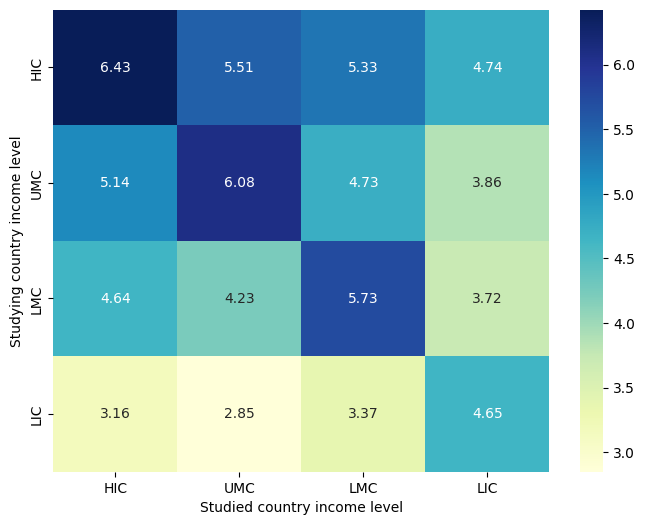

In [245]:
# Define desired order
order = ['HIC', 'UMC', 'LMC', 'LIC']

# Create pivot table
pivot = df.pivot_table(
    index='income_src',
    columns='income_dst',
    values='weight',
    aggfunc='sum'
).fillna(0)

# Reorder rows and columns
pivot = pivot.reindex(index=order, columns=order)

# Apply log10 (adding 1 to avoid log(0))
log_pivot = np.log10(pivot )

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(log_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.ylabel("Studying country income level")
plt.xlabel("Studied country income level")
plt.show()


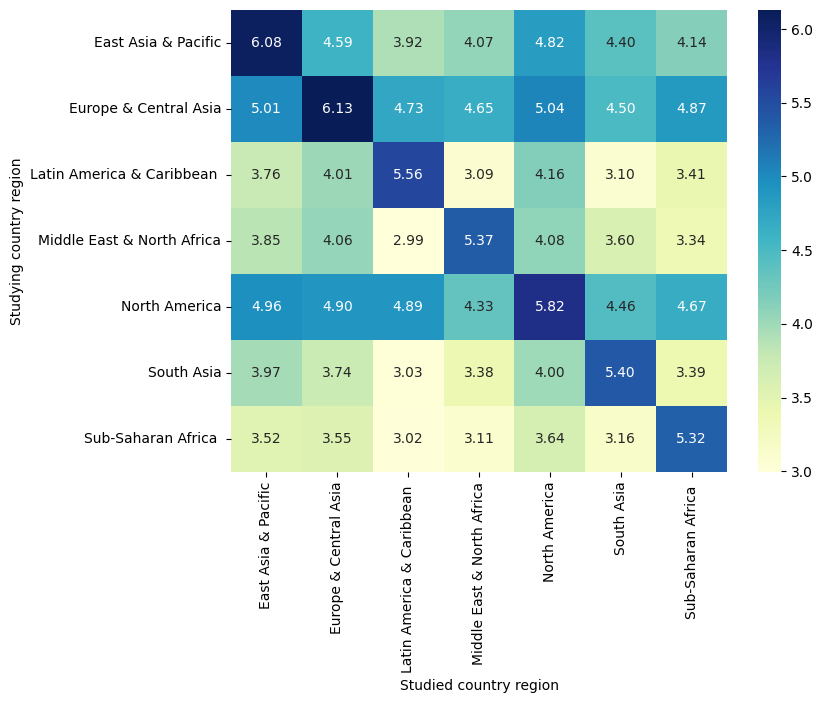

In [246]:
# Create pivot table
pivot = df.pivot_table(
    index='region_src',
    columns='region_dst',
    values='weight',
    aggfunc='sum'
).fillna(0)

# Apply log10 (adding 1 to avoid log(0))
log_pivot = np.log10(pivot)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(log_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.ylabel("Studying country region")
plt.xlabel("Studied country region")
plt.show()


In [ ]:
def build_graph(edges: pd.DataFrame, row_stochastic: bool = False) -> nx.DiGraph:
    """
    edges: DataFrame with ['src','dst','weight']
    row_stochastic: if True, normalize each row i so sum_j w_ij = 1
    """
    df = edges.copy()
    if row_stochastic:
        row_sum = df.groupby('src')['weight'].transform('sum').replace(0, np.nan)
        df['weight'] = df['weight'] / row_sum
        df = df.dropna(subset=['weight'])
    G = nx.DiGraph()
    for _, r in df.iterrows():
        if r['weight'] > 0:
            G.add_edge(r['src'], r['dst'], weight=float(r['weight']))
    return G


In [275]:
usa_df

,region_dst,year,weight
0,North America,1998,2775.586345
1,North America,1999,2933.988951
2,North America,2000,3523.089581
3,North America,2001,3447.616857
4,North America,2002,4377.882666
5,North America,2003,3974.537763
6,North America,2004,3878.446371
7,North America,2005,4325.961222
8,North America,2006,4968.650664
9,North America,2007,5628.130723


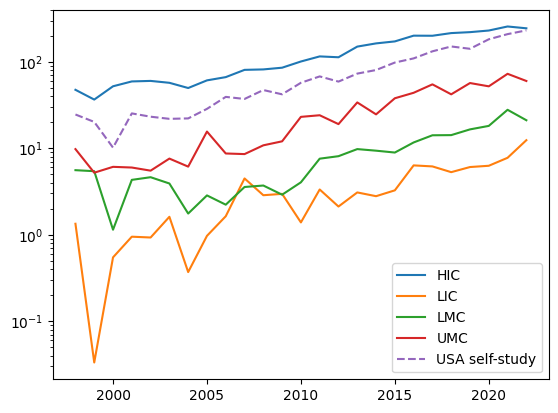

In [299]:
country='zmb'
usa_df=df[(df['dst']==country)&(df['src']!=df['dst'])].groupby(['income_src', 'year'])['weight'].sum().reset_index()
for region in usa_df['income_src'].unique():
    region_df=usa_df[usa_df['income_src']==region]
    plt.plot(region_df['year'], region_df['weight'], label=region)


usa_df_self=df[(df['dst']==country)&(df['src']==df['dst'])].groupby(['region_dst', 'year'])['weight'].sum().reset_index()
plt.plot(usa_df_self['year'], usa_df_self['weight'], label='USA self-study', linestyle='--')
plt.yscale('log')
plt.legend()

In [290]:
final_df[final_df['ratio_self_to_recieved']<0]

,country,self_attention,recieved_attention,given_attention,ratio_self_to_given,incomelevel,region,ratio_self_to_recieved
0,AFG,440.027364,5289.622456,141.759446,2.104043,LIC,South Asia,-0.916813
1,AGO,252.227906,2056.031679,43.276597,4.828275,LMC,Sub-Saharan Africa,-0.877323
2,ALB,1262.780853,1468.684031,215.024976,4.872717,UMC,Europe & Central Asia,-0.140196
3,ARE,5283.176021,6554.750830,3415.089052,0.547010,HIC,Middle East & North Africa,-0.193993
5,ARM,792.117627,1245.994116,303.752189,1.607776,UMC,Europe & Central Asia,-0.364269
...,...,...,...,...,...,...,...,...
148,UZB,1099.649225,1410.576560,333.421997,2.298070,LMC,Europe & Central Asia,-0.220426
149,VNM,12775.599283,15771.960220,2577.600666,3.956392,LMC,East Asia & Pacific,-0.189980
150,YEM,765.176469,1948.532862,257.217260,1.974826,LIC,Middle East & North Africa,-0.607306
152,ZMB,1933.594957,4065.315796,359.659060,4.376189,LMC,Sub-Saharan Africa,-0.524368


In [ ]:


def weighted_reciprocity_global(G: nx.DiGraph) -> float:
    """
    r_w = sum_{i!=j} min(w_ij, w_ji) / sum_{i!=j} w_ij
    """
    num = 0.0
    den = 0.0
    for u, v, d in G.edges(data=True):
        if u==v:
            continue
        w_uv = d.get('weight', 0)
        w_vu = G[v][u]['weight'] if G.has_edge(v, u) else 0.0
        num += min(w_uv, w_vu)
        den += w_uv
    return num / den if den > 0 else np.nan




def weighted_reciprocity_node(G: nx.DiGraph) -> pd.DataFrame:
    """
    r_i(out-based) = sum_j min(w_ij, w_ji) / sum_j w_ij
    Also returns in-based version.
    """
    rows = []
    for i in G.nodes():
        out_w = sum(G[i][j]['weight'] for j in G.successors(i))
        num_out = sum(min(G[i][j]['weight'], G[j][i]['weight']) 
                      for j in G.successors(i) if G.has_edge(j, i))
        r_out = num_out / out_w if out_w > 0 else np.nan

        in_w = sum(G[j][i]['weight'] for j in G.predecessors(i))
        num_in = sum(min(G[i][j]['weight'], G[j][i]['weight']) 
                     for j in G.predecessors(i) if G.has_edge(i, j))
        r_in = num_in / in_w if in_w > 0 else np.nan

        rows.append({'country': i, 'reciprocity_out': r_out, 'reciprocity_in': r_in})
    return pd.DataFrame(rows)



# ---------------------------
# 2) Dyadic asymmetry A_ij and node asymmetry A_i
# ---------------------------
def dyadic_asymmetry_df(G: nx.DiGraph) -> pd.DataFrame:
    """
    A_ij = |w_ij - w_ji| / (w_ij + w_ji), for pairs with w_ij + w_ji > 0
    Returns one row per unordered pair (i<j) with both directions considered.
    """
    seen = set()
    rows = []
    for u, v in G.edges():
        if (v, u) in seen or u == v:
            continue
        w_uv = G[u][v].get('weight', 1.0)
        w_vu = G[v][u]['weight'] if G.has_edge(v, u) else 0.0
        s = w_uv + w_vu
        if s > 0:
            A = abs(w_uv - w_vu) / s
            rows.append({'i': u, 'j': v, 'A_ij': A, 'w_ij': w_uv, 'w_ji': w_vu})
        seen.add((u, v)); seen.add((v, u))
    return pd.DataFrame(rows)

def node_asymmetry(G: nx.DiGraph) -> pd.DataFrame:
    """
    A_i = weighted average of dyadic asymmetry around i with weights (w_ij + w_ji)
    """
    ddf = dyadic_asymmetry_df(G)
    if ddf.empty:
        return pd.DataFrame([{'country': n, 'A_node': np.nan} for n in G.nodes()])
    # expand to two rows per pair to attribute to i and j
    left = ddf[['i','A_ij','w_ij','w_ji']].rename(columns={'i':'country'})
    right = ddf[['j','A_ij','w_ij','w_ji']].rename(columns={'j':'country'})
    left['w_sum'] = left['w_ij'] + left['w_ji']
    right['w_sum'] = right['w_ij'] + right['w_ji']
    all_rows = pd.concat([left[['country','A_ij','w_sum']], right[['country','A_ij','w_sum']]])
    out = all_rows.groupby('country').apply(lambda g: np.average(g['A_ij'], weights=g['w_sum'])).reset_index()
    out.columns = ['country','A_node']
    return out

In [22]:
G=build_graph(df, row_stochastic=False)


In [14]:
node_asymmetry(G).sort_values('A_node', ascending=True).head(10)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_7096\3937359080.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = all_rows.groupby('country').apply(lambda g: np.average(g['A_ij'], weights=g['w_sum'])).reset_index()


,country,A_node
57,hkg,0.262347
83,ltu,0.290204
59,hrv,0.294311
143,tur,0.300188
133,svn,0.302970
75,kor,0.312798
45,est,0.314227
47,fin,0.317352
124,sau,0.319865
61,hun,0.323540


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_7096\3937359080.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = all_rows.groupby('country').apply(lambda g: np.average(g['A_ij'], weights=g['w_sum'])).reset_index()


<Axes: xlabel='A_node', ylabel='Count'>

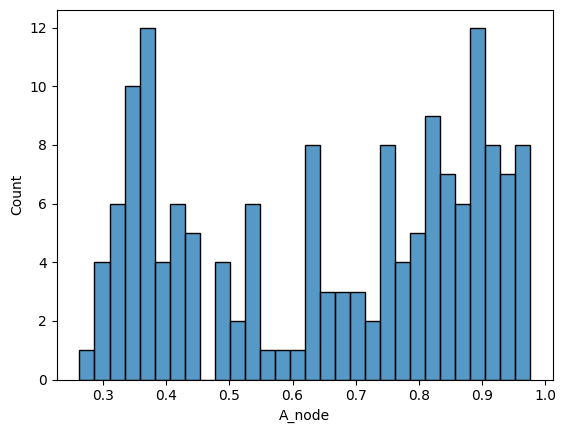

In [15]:
sns.histplot(node_asymmetry(G)['A_node'].dropna(), bins=30)

In [17]:
dyadic_asymmetry_df(G).sort_values('A_ij', ascending=False).head(10)

,i,j,A_ij,w_ij,w_ji
10863,com,zwe,1.0,0.115934,0.0
8191,ner,nam,1.0,0.106808,0.0
8569,omn,ury,1.0,0.022222,0.0
8563,omn,tto,1.0,1.166667,0.0
8561,omn,tcd,1.0,0.041667,0.0
1983,btn,tto,1.0,0.007576,0.0
1984,btn,tun,1.0,0.166667,0.0
1986,btn,uga,1.0,0.250000,0.0
8558,omn,svn,1.0,0.610317,0.0
1991,btn,zaf,1.0,6.847193,0.0


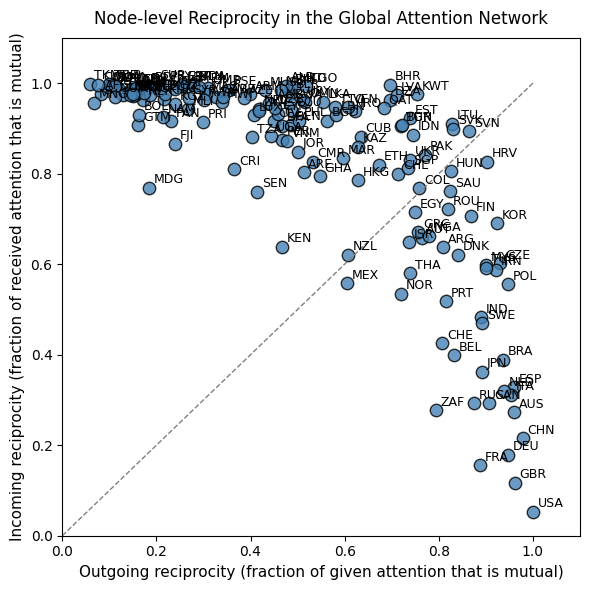

In [23]:
G=build_graph(df, row_stochastic=True)

rec_df=weighted_reciprocity_node(G)
rec_df=rec_df.merge(data, on='country', how='left')
plt.figure(figsize=(6,6))

plt.scatter(
    rec_df['reciprocity_out'], rec_df['reciprocity_in'],
    
    s=80, edgecolor='k', color='steelblue', alpha=0.8
)

# Diagonal = balanced mutuality
plt.plot([0,1], [0,1], ls='--', color='gray', lw=1)

# Labels
plt.xlabel("Outgoing reciprocity (fraction of given attention that is mutual)", fontsize=11)
plt.ylabel("Incoming reciprocity (fraction of received attention that is mutual)", fontsize=11)
plt.title("Node-level Reciprocity in the Global Attention Network", fontsize=12, pad=10)

plt.xlim(0,1.1)
plt.ylim(0,1.1)

# Annotate countries (optional, tidy only key ones)
for _, row in rec_df.iterrows():
    plt.text(
        row['reciprocity_out'] + 0.01,
        row['reciprocity_in'] + 0.01,
        row['country'].upper(),
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [24]:
rec_df=rec_df[rec_df['incomelevel']!='INX']

<Axes: xlabel='reciprocity_out', ylabel='reciprocity_in'>

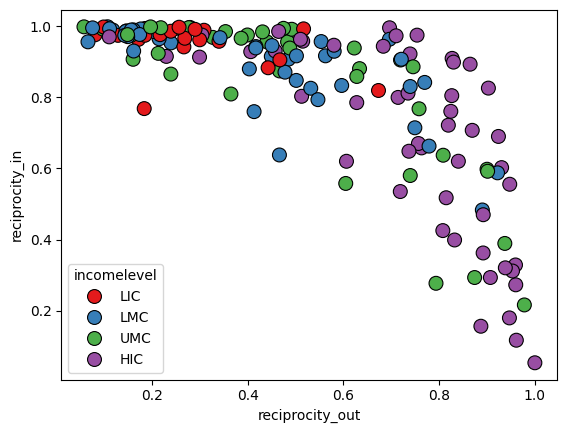

In [25]:
sns.scatterplot(
        data=rec_df, x='reciprocity_out', y='reciprocity_in',hue_order=['LIC','LMC','UMC','HIC'],
        hue='incomelevel', palette='Set1', s=100, edgecolor='k'
    )


In [ ]:
def centralities(G: nx.DiGraph) -> pd.DataFrame:
    in_strength = {n: sum(G[p][n]['weight'] for p in G.predecessors(n)) for n in G.nodes()}
    out_strength = {n: sum(G[n][p]['weight'] for p in G.successors(n)) for n in G.nodes()}
    pr = nx.pagerank(G, weight='weight') if G.number_of_edges() else {n: np.nan for n in G.nodes()}
    # HITS (authority ~ gets; hub ~ gives)
    try:
        hubs, auth = nx.hits_numpy(G, max_iter=1000, normalized=True)
    except nx.PowerIterationFailedConvergence:
        hubs = {n: np.nan for n in G.nodes()}
        auth = {n: np.nan for n in G.nodes()}
    df = pd.DataFrame({
        'country': list(G.nodes()),
        'in_strength': [in_strength[n] for n in G.nodes()],
        'out_strength': [out_strength[n] for n in G.nodes()],
        'pagerank': [pr[n] for n in G.nodes()],
        'hub_score': [hubs[n] for n in G.nodes()],
        'authority_score': [auth[n] for n in G.nodes()],
    })
    return df

# ---------------------------
# 4) Domestic share & EI (external-internal) index
# ---------------------------
def domestic_share_EI(G: nx.DiGraph, use_row_stochastic: bool = True) -> pd.DataFrame:
    """
    Domestic (self-loop) share p_dom_out = w_ii / sum_j w_ij.
    EI_out = (E_ext - E_dom) / (E_ext + E_dom) = 1 - 2 * p_dom_out  (if sums normalized)
    If graph is not row-stochastic, we compute with raw weights.
    """
    rows = []
    for i in G.nodes():
        out_sum = sum(G[i][j]['weight'] for j in G.successors(i))
        w_ii = G[i][i]['weight'] if G.has_edge(i, i) else 0.0
        p_dom = (w_ii / out_sum) if out_sum > 0 else np.nan
        if use_row_stochastic:
            EI = 1 - 2 * p_dom if p_dom == p_dom else np.nan  # NaN-safe
        else:
            ext = out_sum - w_ii
            EI = (ext - w_ii) / (ext + w_ii) if (ext + w_ii) > 0 else np.nan
        rows.append({'country': i, 'p_dom_out': p_dom, 'EI_out': EI})
    return pd.DataFrame(rows)

# ---------------------------
# 5) Assortativity by node attribute (e.g., region / incomelevel)
#     (computed on an undirected projection for stability)
# ---------------------------
def assortativity_by_attribute(G: nx.DiGraph, attrs: pd.DataFrame, attr_col: str) -> float:
    """
    Returns attribute assortativity coefficient (Newman) on undirected version.
    """
    H = G.to_undirected()
    attr_map = dict(zip(attrs['country'], attrs[attr_col]))
    nx.set_node_attributes(H, attr_map, attr_col)
    # NetworkX handles categorical assortativity via attribute_assortativity_coefficient
    return nx.attribute_assortativity_coefficient(H, attr_col)

# ---------------------------
# 6) Community detection (undirected) + Participation coef & within-module z
# ---------------------------
from networkx.algorithms.community import greedy_modularity_communities

def communities_participation_within_z(G: nx.DiGraph) -> pd.DataFrame:
    """
    Detects undirected weighted communities (greedy modularity),
    then computes participation coefficient P_i and within-module z-score z_i
    using weighted degrees.
    """
    H = G.to_undirected()
    for u, v, d in H.edges(data=True):
        if 'weight' not in d:
            d['weight'] = 1.0
    comms = list(greedy_modularity_communities(H, weight='weight'))
    # map node -> module id
    comm_id = {}
    for cid, cset in enumerate(comms):
        for n in cset:
            comm_id[n] = cid
    # Strengths by module
    total_w = {n: 0.0 for n in H.nodes()}
    by_mod = {n: defaultdict(float) for n in H.nodes()}
    for u, v, d in H.edges(data=True):
        w = d['weight']
        total_w[u] += w
        total_w[v] += w
        by_mod[u][comm_id[v]] += w
        by_mod[v][comm_id[u]] += w

    # Participation coefficient
    P = {}
    for n in H.nodes():
        if total_w[n] == 0:
            P[n] = np.nan
        else:
            frac_sq = [(w_m/total_w[n])**2 for w_m in by_mod[n].values()]
            P[n] = 1.0 - sum(frac_sq)

    # Within-module z-score
    z = {}
    for cid, cset in enumerate(comms):
        ks = []
        for n in cset:
            # within-module strength: sum of weights to nodes in same module
            k_in = sum(H[n][m]['weight'] for m in H.neighbors(n) if comm_id[m]==cid)
            ks.append(k_in)
        mu = np.mean(ks) if ks else 0.0
        sd = np.std(ks, ddof=1) if len(ks) > 1 else 0.0
        for n in cset:
            k_in = sum(H[n][m]['weight'] for m in H.neighbors(n) if comm_id[m]==cid)
            z[n] = (k_in - mu) / sd if sd > 0 else 0.0

    return pd.DataFrame({
        'country': list(H.nodes()),
        'community': [comm_id[n] for n in H.nodes()],
        'participation_coeff': [P[n] for n in H.nodes()],
        'within_module_z': [z[n] for n in H.nodes()]
    })

# ---------------------------
# 7) Bow-tie decomposition (IN / SCC / OUT / tendrils)
# ---------------------------
def bow_tie_decomposition(G: nx.DiGraph, threshold: float = None) -> pd.DataFrame:
    """
    Classify nodes into IN, SCC, OUT, Tendrils/Disconnected.
    If threshold is provided, binarize edges with weight >= threshold; else use existing edges.
    """
    if threshold is not None:
        H = nx.DiGraph()
        for u, v, d in G.edges(data=True):
            if d.get('weight', 0.0) >= threshold:
                H.add_edge(u, v)
    else:
        H = G.copy()

    # largest strongly connected component
    sccs = list(nx.strongly_connected_components(H))
    if not sccs:
        return pd.DataFrame({'country': list(H.nodes()), 'bowtie': 'Disconnected'})
    L = max(sccs, key=len)
    in_SCC = set()
    out_SCC = set()
    Lset = set(L)

    # Nodes reachable from SCC (OUT)
    OUT = set()
    for n in L:
        OUT |= nx.descendants(H, n)
    OUT -= Lset

    # Nodes that can reach SCC (IN)
    IN = set()
    # Use reverse graph for efficiency
    Hr = H.reverse(copy=False)
    for n in L:
        IN |= nx.descendants(Hr, n)
    IN -= Lset

    labels = {}
    for n in H.nodes():
        if n in Lset:
            labels[n] = 'SCC'
        elif n in IN:
            labels[n] = 'IN'
        elif n in OUT:
            labels[n] = 'OUT'
        else:
            labels[n] = 'Tendril/Disconnected'

    return pd.DataFrame({'country': list(H.nodes()), 'bowtie': [labels[n] for n in H.nodes()]})

# ---------------------------
# 8) Gravity residuals (size & distance baseline)
# ---------------------------
def gravity_residuals(edges: pd.DataFrame,
                      attrs: pd.DataFrame,
                      dist_df: pd.DataFrame,
                      size_cols=('gdp_per_capita','population'),
                      distance_col='km') -> pd.DataFrame:
    """
    Fit a gravity baseline: log w_ij ~ const + sum(log size_i) + sum(log size_j) - alpha log distance_ij
    Return residuals by dyad and domestic/external residual sums by node (outgoing side).
    Requires: dist_df with ['src','dst', distance_col]
    """
    df = edges.merge(dist_df, on=['src','dst'], how='left')
    A = attrs.set_index('country')

    # Build design matrix
    def safe_log(x):
        return np.log(np.clip(x, 1e-12, None))

    X_rows = []
    y = []
    valid_mask = []
    for _, r in df.iterrows():
        i, j, w = r['src'], r['dst'], r['weight']
        if w <= 0 or i not in A.index or j not in A.index or pd.isna(r[distance_col]) or r[distance_col] <= 0:
            valid_mask.append(False)
            continue
        xi = []
        for col in size_cols:
            xi.append(safe_log(A.loc[i, col]))  # size_i
            xi.append(safe_log(A.loc[j, col]))  # size_j
        xi.append(-safe_log(r[distance_col]))   # -alpha * log(dist)
        X_rows.append([1.0] + xi)              # include intercept
        y.append(np.log(w))
        valid_mask.append(True)

    if not X_rows:
        raise ValueError("No valid dyads for gravity model. Check attrs/distances/weights.")
    X = np.array(X_rows)
    y = np.array(y)

    # OLS
    model = sm.OLS(y, X).fit()
    # collect residuals back to dyads
    resid = []
    idx = 0
    for k, r in df.iterrows():
        if valid_mask[k]:
            resid.append(model.resid[idx])
            idx += 1
        else:
            resid.append(np.nan)
    df['gravity_resid'] = resid

    # Summaries per source country: domestic vs external residual sums
    def is_dom(row): 
        return row['src'] == row['dst']
    dom = df.groupby('src').apply(lambda g: g.loc[g['src']==g['dst'], 'gravity_resid'].sum(skipna=True)).rename('domestic_resid')
    ext = df.groupby('src').apply(lambda g: g.loc[g['src']!=g['dst'], 'gravity_resid'].sum(skipna=True)).rename('external_resid')
    out = pd.concat([dom, ext], axis=1).reset_index().rename(columns={'src':'country'})
    return df[['src','dst','weight','gravity_resid']].rename(columns={'src':'i','dst':'j'}), out

# ---------------------------
# 9) Convenience: run all core node measures
# ---------------------------
def compute_all_measures(edges, attrs=None, row_stochastic=True, assort_attr=None, bowtie_threshold=None):
    G = build_graph(edges, row_stochastic=row_stochastic)
    rec_node = weighted_reciprocity_node(G)
    A_node = node_asymmetry(G)
    cents = centralities(G)
    dom = domestic_share_EI(G, use_row_stochastic=row_stochastic)
    # merge
    out = cents.merge(rec_node, on='country', how='left').merge(A_node, on='country', how='left').merge(dom, on='country', how='left')
    # communities
    comm_df = communities_participation_within_z(G)
    out = out.merge(comm_df, on='country', how='left')
    # bow-tie
    bt = bow_tie_decomposition(G, threshold=bowtie_threshold)
    out = out.merge(bt, on='country', how='left')
    # assortativity (global scalar)
    assort = None
    if attrs is not None and assort_attr is not None and assort_attr in attrs.columns:
        assort = assortativity_by_attribute(G, attrs, assort_attr)
    return G, out, assort

# ---------------------------
# Example usage (pseudo):
# edges = pd.DataFrame({
#     'src': ['USA','USA','FRA','DEU','IRN','IRN'],
#     'dst': ['USA','DEU','FRA','USA','IRN','USA'],
#     'weight': [100, 30, 50, 40, 60, 10]
# })
# attrs = pd.DataFrame({
#     'country': ['USA','DEU','FRA','IRN'],
#     'region': ['NA','EU','EU','MENA'],
#     'incomelevel': ['HIC','HIC','HIC','LMC'],
#     'gdp_per_capita': [60000, 50000, 45000, 6000],
#     'population': [3.3e8, 8.3e7, 6.7e7, 8.5e7],
#     'researchers': [1.5e6, 3.5e5, 3.0e5, 1.5e5]
# })
# G, node_measures, assort_region = compute_all_measures(
#     edges, attrs=attrs, row_stochastic=True, assort_attr='region', bowtie_threshold=None
# )
# print("Global weighted reciprocity:", weighted_reciprocity_global(G))
# print("Assortativity by region:", assort_region)
# node_measures.head()
# --------------------------------------------


In [174]:
self_df=df[df['src']==df['dst']].drop(columns=['src']).rename(columns={'weight':'self_attention', 'dst':'country'})
out_df=df[df['src']!=df['dst']].groupby(by=['src'])['weight'].sum().reset_index().rename(columns={'weight':'given_attention', 'src':'country'})
in_df=df[df['src']!=df['dst']].groupby(by=['dst'])['weight'].sum().reset_index().rename(columns={'weight':'recieved_attention', 'dst':'country'})
final_df=self_df.merge(in_df, how='outer', on=['country']).merge(out_df, how='outer', on=['country']).fillna(0)
###########
final_df=final_df.groupby('country').agg({'self_attention':'sum', 'recieved_attention':'sum', 'given_attention':'sum'}).reset_index()

In [228]:
final_df['ratio_self_to_recieved']=final_df['self_attention']/(final_df['recieved_attention'])-1

final_df['ratio_self_to_given']=final_df['self_attention']/(final_df['given_attention'])-1

In [234]:
final_df['incomelevel']=final_df['country'].apply(lambda x: x.lower()).map(data.set_index('country')['incomelevel'])
final_df['region']=final_df['country'].apply(lambda x: x.lower()).map(data.set_index('country')['region'])

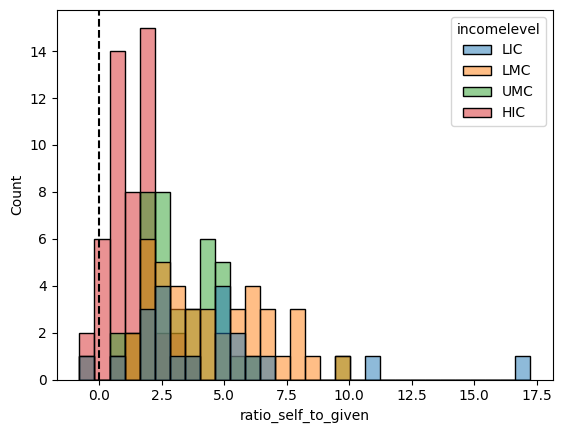

In [236]:
sns.histplot(data=final_df, x='ratio_self_to_given', hue='incomelevel', bins=30)
plt.axvline(0, color='k', ls='--')


In [85]:
final_df['ABI'] = (final_df['total_recieved'] - final_df['total_given']) / \
                  (final_df['total_recieved'] + final_df['total_given'] + 1e-9)

final_df['SRR'] = final_df['self_attention'] / (final_df['total_recieved'] + 1e-9)

final_df['SI'] = (final_df['self_attention'] + 
                  np.minimum(final_df['total_recieved'], final_df['total_given'])) / \
                 (final_df['self_attention'] + final_df['total_recieved'] + final_df['total_given'] + 1e-9)

<Axes: xlabel='ratio_self_to_given', ylabel='region'>

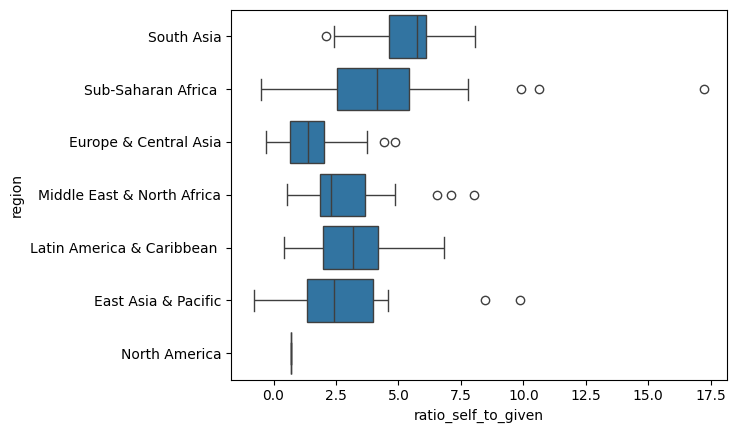

In [237]:
sns.boxplot(data=final_df, y='region', x='ratio_self_to_given')

In [209]:
final_df['country']=final_df['country'].apply(lambda x: x.upper())

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_7096\1807016634.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


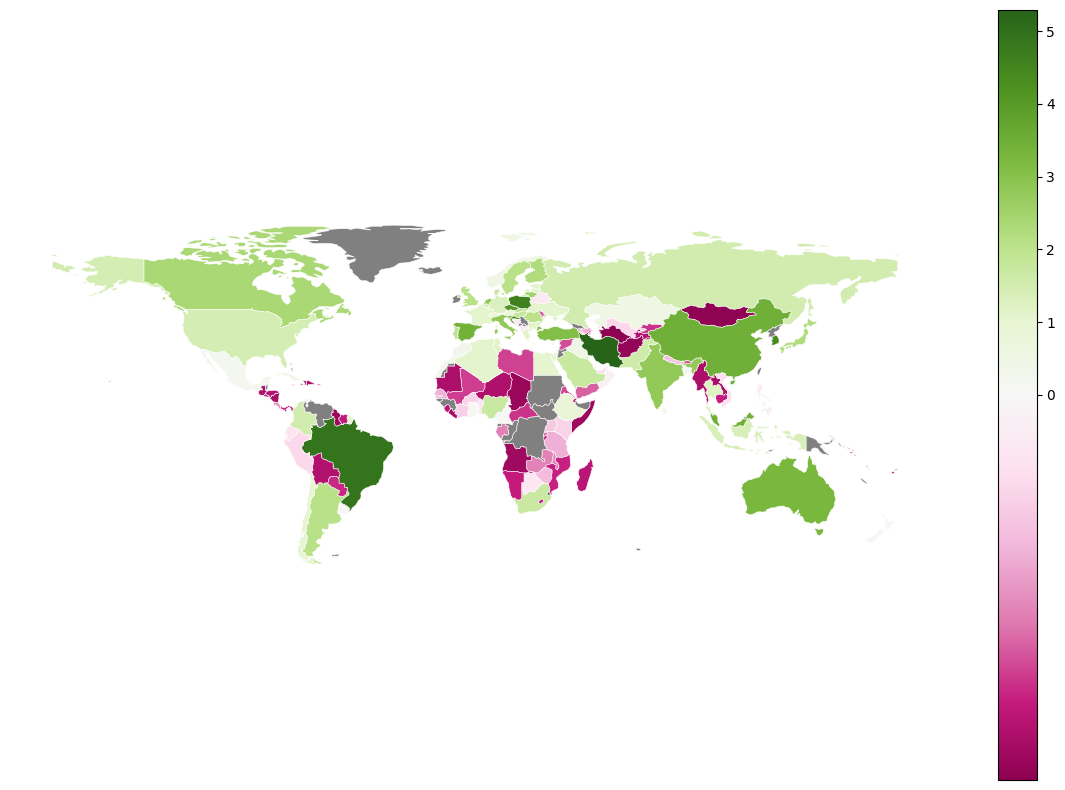

In [227]:

from matplotlib.colors import TwoSlopeNorm

# --- Compute ratio ---
tmp = final_df.copy()
tmp['ratio_self_to_received'] = tmp['self_attention'] / tmp['recieved_attention'].replace(0, np.nan)-1

# --- Aggregate by country ---
ratio_map = (
    tmp.groupby('country', as_index=False)
       .agg(ratio_self_to_received=('ratio_self_to_received', 'mean'))
)

# --- Load world map ---
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[world['name'] != 'Antarctica']  # optional

# --- Merge ---
world_ratio = world.merge(ratio_map, how='left', left_on='iso_a3', right_on='country')

# --- Compute min, max, and midpoint for diverging normalization ---
vmin = world_ratio['ratio_self_to_received'].min()
vmax = world_ratio['ratio_self_to_received'].max()
vcenter = 0  # Equal attention line

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# --- Plot ---
fig, ax = plt.subplots(figsize=(15, 10))
world_ratio.plot(
    column="ratio_self_to_received",
    cmap="PiYG",                # diverging colormap (or "PiYG", "RdBu", etc.)
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True,
    norm=norm,
    missing_kwds={"color": "grey", "label": "No data"},
)

ax.axis("off")

plt.show()


In [239]:

from matplotlib.colors import TwoSlopeNorm

# --- Compute ratio ---
tmp = final_df.copy()

# --- Load world map ---
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[world['name'] != 'Antarctica']  # optional

# --- Merge ---
world_ratio = world.merge(ratio_map, how='left', left_on='iso_a3', right_on='country')

# --- Compute min, max, and midpoint for diverging normalization ---
vmin = world_ratio['ratio_self_to_given'].min()
vmax = world_ratio['ratio_self_to_given'].max()
vcenter = 0  # Equal attention line

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# --- Plot ---
fig, ax = plt.subplots(figsize=(15, 10))
world_ratio.plot(
    column="ratio_self_to_given",
    cmap="PiYG",                # diverging colormap (or "PiYG", "RdBu", etc.)
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True,
    norm=norm,
    missing_kwds={"color": "grey", "label": "No data"},
)

ax.axis("off")

plt.show()


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_7096\974815079.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


KeyError: 'ratio_self_to_given'

In [216]:
vmin

0.06084257067721325

In [124]:
df

,country,self_attention,recieved_attention,given_attention,total_recieved,total_given,ABI,SRR,SI,incomelevel,region,gdp_per_capita,population,padded_population_of_researchers
0,AFG,287.723714,4482.929491,105.489910,4770.653204,393.213623,0.847706,0.060311,0.124906,LIC,South Asia,431.247390,2.840399e+07,154.318182
1,AGO,198.664263,1744.814141,34.777944,1943.478404,233.442207,0.785530,0.102221,0.181895,LMC,Sub-Saharan Africa,2470.965963,2.323220e+07,111.782609
2,ALB,973.173573,1227.530802,167.082735,2200.704374,1140.256308,0.317408,0.442210,0.489885,UMC,Europe & Central Asia,3392.698561,2.958454e+06,590.391304
3,ARE,3810.850521,5049.462306,2621.915186,8860.312827,6432.765707,0.158735,0.430103,0.536205,HIC,Middle East & North Africa,38822.422027,6.615256e+06,3378.826087
4,ARG,28406.611821,9232.662268,6511.908116,37639.274089,34918.519937,0.037498,0.754707,0.627203,UMC,Latin America & Caribbean,9109.862821,4.069060e+07,30447.739130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,VNM,8083.658941,13173.885220,1708.506128,21257.544161,9792.165069,0.369259,0.380272,0.456792,LMC,East Asia & Pacific,1618.434497,8.676922e+07,6476.434783
141,YEM,648.756813,1637.883801,172.233095,2286.640614,820.989909,0.471630,0.283716,0.391266,LIC,Middle East & North Africa,903.667838,2.439092e+07,358.434783
142,ZAF,46714.248687,17718.697082,15666.044821,64432.945768,62380.293507,0.016186,0.725006,0.628687,UMC,Sub-Saharan Africa,5815.279354,5.173774e+07,22274.695652
143,ZMB,1493.484996,3357.851029,281.720301,4851.336025,1775.205297,0.464214,0.307850,0.402547,LMC,Sub-Saharan Africa,1066.544667,1.360670e+07,701.391304
